# Anomaly Detection in Time Series Family via RNNs

This code shows how Recurrent Neural Networks can be used to detect anomalies in intraday data, specifically <em>power consumption</em> for different days.

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Data Exploration 

In [18]:
os.listdir()

d = pd.read_csv('datos_tienda.csv')
d=d.set_index(['date','time'])
d.head()

Analizador Chiller Potencia Activa (KW)  \
date       time                                             
01/08/2017 00:00                                 1.873695   
           01:00                                 1.833749   
           02:00                                 1.856977   
           03:00                                 1.852570   
           04:00                                 1.864120   

                  Analizador General Potencia Activa (KW)  \
date       time                                             
01/08/2017 00:00                                 5.940129   
           01:00                                 5.863945   
           02:00                                 5.936164   
           03:00                                 5.813366   
           04:00                                 5.780504   

                  Temperatura Ambiente (ºC) CL01 Ventas  \
date       time                                           
01/08/2017 00:00                              24.358182   
           01:00                              24.301818   
           02:00                              24.285455   
           03:00                              24.296364   
           04:00                              24.300909   

                  Temperatura Ambiente (ºC) CL02 Ventas  \
date       time                                           
01/08/2017 00:00                              25.788182   
           01:00                              25.844545   
           02:00                              25.896364   
           03:00                              25.900000   
           04:00                              25.910909   

                  Temperatura Ambiente (ºC) CL03 Almacén  \
date       time                                            
01/08/2017 00:00                               23.729091   
           01:00                               23.600000   
           02:00                               23.600000   
           03:00                               23.600000   
           04:00                               23.600000   

                  Temperatura Impulsión (ºC) CL01 Ventas  \
date       time                                            
01/08/2017 00:00                               24.091818   
           01:00                               24.200000   
           02:00                               24.241818   
           03:00                               24.392727   
           04:00                               24.437273   

                  Temperatura Impulsión (ºC) CL02 Ventas  \
date       time                                            
01/08/2017 00:00                               23.307273   
           01:00                               23.403636   
           02:00                               23.496364   
           03:00                               23.548182   
           04:00                               23.600909   

                  Temperatura Impulsión (ºC) CL03 Almacén  \
date       time                                             
01/08/2017 00:00                                23.688182   
           01:00                                23.697273   
           02:00                                23.728182   
           03:00                                23.658182   
           04:00                                23.680909   

                  Temperatura Retorno (ºC) Agua CL01 Ventas  \
date       time                                               
01/08/2017 00:00                                  19.479091   
           01:00                                  19.808182   
           02:00                                  20.038182   
           03:00                                  20.249091   
           04:00                                  20.459091   

                  Temperatura Retorno (ºC) Agua CL02 Ventas  \
date       time                                               
01/08/2017 00:00                                  19.881818   
           0

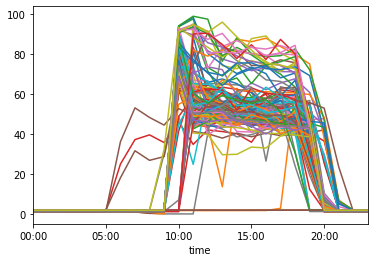

In [19]:
name= 'Analizador Chiller Potencia Activa (KW)'
for day in d.index.levels[0]:
    d.loc[day][name].plot()

## Recurrent Neural Network Model

The model below is a standard Recurrent Neural Network, trained with a full pass (no truncated backpropagation) over each time series.

In [4]:
tf.reset_default_graph()

## NN params

state_size = 10
batch_size = 119
n_steps = 24

## prepare RNN components

X=tf.placeholder(tf.float32,[batch_size,n_steps],'input')
Y=tf.placeholder(tf.float32,[batch_size,n_steps],'output')

state0 = tf.zeros([batch_size,state_size],tf.float32)

with tf.variable_scope('rnn_cell'):
    # updating hidden state
    W_hh = tf.get_variable('W_hh',(state_size+1,state_size),tf.float32)
    b_hh = tf.get_variable('b_hh',(state_size,),initializer=tf.constant_initializer(0.0))
    # mapping hidden state to output
    W_hy = tf.get_variable('W_hy',(state_size,),tf.float32)
    b_hy = tf.get_variable('b_hy',(1,),initializer=tf.constant_initializer(0.0))
    
def forward_pass(cur_state,cur_input):
    # one recursion step
    with tf.variable_scope('rnn_cell',reuse=True):
        W_hh = tf.get_variable('W_hh')
        b_hh = tf.get_variable('b_hh')
        W_hy = tf.get_variable('W_hy')
        b_hy = tf.get_variable('b_hy')
        h_next = tf.tanh(tf.tensordot(tf.concat([cur_state,tf.expand_dims(cur_input,-1)],axis=1),W_hh,axes=[[-1],[0]])+b_hh)
        y = tf.tensordot(h_next,W_hy,axes=[[-1],[0]])+b_hy
        return (h_next,y)

## build the model (recursion truncated, applied n_steps times)

state = state0
states = []
ys = []
X_slices = tf.unstack(X,axis=1)
for X_slice in X_slices:
    state,y_slice = forward_pass(state,X_slice)
    states.append(state)
    ys.append(y_slice)

## build and optimize the loss function

Y_pred = tf.stack(ys,1)
loss = tf.losses.mean_squared_error(Y,Y_pred)
optimize = tf.train.AdamOptimizer().minimize(loss)

In [5]:
## training data - normalization per series

Y_train = np.array([d.loc[day][name].values for day in d.index.levels[0]])
X_train = Y_train.copy()
for i in range(Y_train.shape[0]):
    Y_train[i] = (Y_train[i]-Y_train[i].mean())/Y_train[i].std()
    X_train[i] = np.concatenate([[0],Y_train[i][:-1]])

In [6]:
## actual training

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        loss_val,y_pred_val,_ = sess.run([loss,Y_pred,optimize],feed_dict={X:X_train,Y:Y_train})
        if i%50==0:
            print(loss_val)
        

1.2418616
0.5485334
0.37079644
0.30486536
0.27148882
0.25203776
0.24081959
0.23254925
0.22562897
0.21945302
0.21334115
0.20655124
0.19882861
0.19000076
0.18060978
0.17134002
0.16281833
0.15533376
0.14808142
0.14245528


## Results

Let's look at 10 most common and most untypical cases. We see that untypical cases are due to 
<ul>
    <li> different opening hours </li>
    <li> high daily fluctuations </li>
</ul>

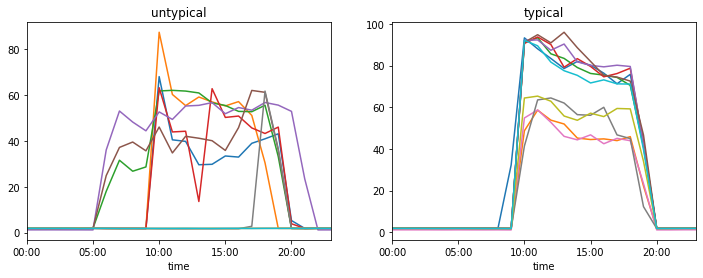

In [17]:
losses=np.square(Y_train-y_pred_val).mean(-1)

fig,axs=plt.subplots(1,2,figsize=(12,4))

bad_idxs=np.argsort(losses)[-10:]
bad_days=d.index.levels[0][bad_idxs]
for day in bad_days:
    d.loc[day,name].plot(ax=axs[0])
axs[0].set_title('untypical')
    
good_idxs=np.argsort(losses)[:10]
good_days=d.index.levels[0][good_idxs]
for day in good_days:
    d.loc[day,name].plot(ax=axs[1])
axs[1].set_title('typical')
plt.show()
